# PART B:  Understanding the task of complex word identification

### Description

The English dataset consists of mixture of professionally written news, non-professionally written news (WikiNews), and Wikipedia articles. Spanish and German datasets contain data taken from Spanish and German Wikipedia pages. The French dataset contains data taken from French Wikipedia pages. Each sentence in the English dataset was annotated by 10 native and 10 non-native speakers. Annotators were provided with the surrounding context of each sentence, i.e. a paragraph, then asked to mark words they think would be difficult to understand for children, non-native speakers, and people with language disabilities.

### Data Format
`<ID> Both China and the Philippines flexed their muscles on Wednesday. 31 51 flexed their muscles 10 10 3 2 1 0.25
<ID> Both China and the Philippines flexed their muscles on Wednesday. 31 37 flexed 10 10 2 6 1 0.4
<ID> Both China and the Philippines flexed their muscles on Wednesday. 44 51 muscles 10 10 0 0 0 0.0`

Each line represents a sentence with one complex word annotation and relevant information, each separated by a TAB character.

    The first column shows the HIT ID of the sentence. All sentences with the same ID belong to the same HIT.
    The second column shows the actual sentence where there exists a complex phrase annotation.
    The third and fourth columns display the start and end offsets of the target word in this sentence.
    The fifth column represents the target word.
    The sixth and seventh columns show the number of native annotators and the number of non-native annotators who saw the sentence.
    The eighth and ninth columns show the number of native annotators and the number of non-native annotators who marked the target word as difficult.
    The tenth and eleventh columns show the gold-standard label for the binary and probabilistic classification tasks.

The labels in the binary classification task were assigned in the following manner:

    0: *simple* word (none of the annotators marked the word as difficult)
    1: *complex* word (at least one annotator marked the word as difficult)

The labels in the probabilistic classification task were assigned as `<the number of annotators who marked the word as difficult>/<the total number of annotators>`.

In [1]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
df = pd.read_csv('../datas/News_Train.tsv', sep='\t',header=None)

data = df.set_axis(['id','sentence','start','end','trgt','nat_ann','nonnat_ann','nat_diff','non_diff','label','prob'],
                  axis=1, inplace=False)

data.head()

,id,sentence,start,end,trgt,nat_ann,nonnat_ann,nat_diff,non_diff,label,prob
0,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,10,barren,10,10,6,2,1,0.40
1,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,18,barren islands,10,10,0,1,1,0.05
2,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",20,25,reefs,10,10,1,2,1,0.15
3,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",11,18,islands,10,10,0,0,0,0.00
4,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",30,35,coral,10,10,0,0,0,0.00


In [3]:
data['label']

0        1
1        1
2        1
3        0
4        0
        ..
13997    1
13998    0
13999    0
14000    0
14001    0
Name: label, Length: 14002, dtype: int64

In [4]:
label_zero = data[(data["label"] == 0)]
num_of_inst_0 = len(label_zero)
print(num_of_inst_0)

8459


In [5]:
label_one = data[(data["label"] == 1)]
num_of_inst_1 = len(label_one)
print(num_of_inst_1)

5543


In [6]:
data.describe()

,start,end,nat_ann,nonnat_ann,nat_diff,non_diff,label,prob
count,14002.000000,14002.000000,14002.0,14002.0,14002.000000,14002.000000,14002.000000,14002.000000
mean,83.727753,92.100486,10.0,10.0,0.902014,0.860591,0.395872,0.088130
std,66.602408,66.819266,0.0,0.0,1.949611,1.894848,0.489055,0.181183
min,0.000000,2.000000,10.0,10.0,0.000000,0.000000,0.000000,0.000000
25%,32.000000,40.000000,10.0,10.0,0.000000,0.000000,0.000000,0.000000
50%,71.000000,79.000000,10.0,10.0,0.000000,0.000000,0.000000,0.000000
75%,120.000000,129.000000,10.0,10.0,1.000000,1.000000,1.000000,0.100000
max,647.000000,656.000000,10.0,10.0,10.000000,10.000000,1.000000,1.000000


### Min, max, median, mean, and stdev of the probabilistic label

In [7]:
min_prob_label = data["prob"].min()
max_prob_label = data["prob"].max()
mean_prob_label = data["prob"].mean()
median_prob_label = data["prob"].median()
std_prob_label = data["prob"].std()

In [8]:
data['trgt']

0                  barren
1          barren islands
2                   reefs
3                 islands
4                   coral
               ...       
13997    security partner
13998            security
13999             partner
14000              troops
14001                home
Name: trgt, Length: 14002, dtype: object

 ### Number of instances consisting of more than one token

In [9]:
nlp = spacy.load("en_core_web_sm")

num_inst_mor_one_token = 0

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc.noun_chunks:
        if len(np) > 1:
            num_inst_mor_one_token += 1

print("Number of instances consisting of more than one token : ",num_inst_mor_one_token) # 1624

Number of instances consisting of more than one token :  1624


### Maximum number of tokens for an instance

In [10]:
max_num_of_tokens = 0
maximum_token = ''

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc.noun_chunks:
        if len(np) > max_num_of_tokens:
            max_num_of_tokens = len(np)
            maximum_token = np.text

print("Maximum number of tokens for an instance : ",max_num_of_tokens) # 7
print("The maximum token instance : ",maximum_token) # state-owned RIA Novosti news agency

Maximum number of tokens for an instance :  7
The maximum token instance :  state-owned RIA Novosti news agency


# 8.Explore linguistic characteristics
For simplicity, we will focus on the instances which consist only of a **single token** and have been labeled as **complex** by at least one annotator. Calculate the length of the tokens as the number of characters. Calculate the frequency of the tokens using the `wordfreq` package.

In [11]:
total_tokens_length = 0

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc.noun_chunks:
        total_tokens_length += len(np.text)

print("The length of the tokens:", total_tokens_length) # 78330

The length of the tokens: 78330


In [12]:
from wordfreq import zipf_frequency, word_frequency

In [13]:
frequency_of_tokens = {}
freq_list = []

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc.noun_chunks:
        if len(np) == 1:
            frequency = zipf_frequency(np.text, 'en', wordlist='small')
            frequency_of_tokens.update({np.text: frequency})
            freq_list.append(frequency)

        
print(list(frequency_of_tokens.items())[:10])
print(freq_list[:10])

[('barren', 3.4), ('islands', 4.5), ('coral', 3.86), ('outcrops', 0.0), ('oil', 5.1), ('gas', 5.01), ('Asia', 4.65), ('conflict', 4.64), ('flexed', 0.0), ('China', 5.1)]
[3.4, 4.5, 3.86, 0.0, 5.1, 5.01, 4.65, 4.64, 0.0, 5.1]


In [14]:
instance = data["prob"]
instance

0        0.40
1        0.05
2        0.15
3        0.00
4        0.00
         ... 
13997    0.10
13998    0.00
13999    0.00
14000    0.00
14001    0.00
Name: prob, Length: 14002, dtype: float64

In [15]:
one_token_df = []

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc.noun_chunks:
        if len(np) == 1:
            one_token_df.append(len(np.text))
            
#print(one_token_df)

In [16]:
token_1_df = pd.DataFrame()
token_1_df['single_tokens'] = one_token_df
token_1_df['comp_prob'] = instance
token_1_df.dropna()

,single_tokens,comp_prob
0,6,0.40
1,7,0.05
2,5,0.15
3,8,0.00
4,3,0.00
...,...,...
7835,6,0.00
7836,8,0.05
7837,7,0.00
7838,6,0.00


### Provide the Pearson correlation of length and frequency with the probabilistic complexity label.

In [17]:
token_1_df.corr()

,single_tokens,comp_prob
single_tokens,1.0000,0.0005
comp_prob,0.0005,1.0000


In [18]:
token_2_df = pd.DataFrame()
token_2_df['comp_prob'] = instance[:7840]
token_2_df['freq'] = freq_list
token_2_df.dropna()

,comp_prob,freq
0,0.40,3.40
1,0.05,4.50
2,0.15,3.86
3,0.00,0.00
4,0.00,5.10
...,...,...
7835,0.00,5.52
7836,0.05,5.20
7837,0.00,4.84
7838,0.00,4.64


In [19]:
token_2_df.corr()

,comp_prob,freq
comp_prob,1.000000,0.015593
freq,0.015593,1.000000


In [20]:
from scipy.stats import pearsonr

pearsonr(token_2_df['comp_prob'],token_2_df['freq'])

(0.015593253027188968, 0.16741759505648648)

### Provide 3 scatter plots with the probabilistic complexity on the y-axis. 

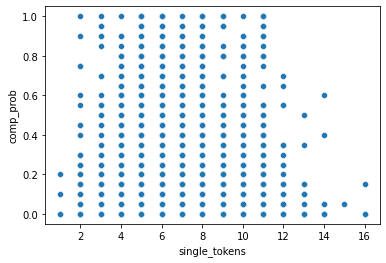

In [21]:
sns_plot = sns.scatterplot(x="single_tokens", y="comp_prob", data=token_1_df);
plt.savefig('token_scatter.png')

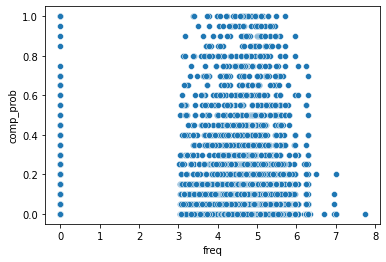

In [22]:
sns.scatterplot(x="freq", y="comp_prob", data=token_2_df);
plt.savefig('freq_scatter.png')

In [23]:
pos_tags_dict = {}
pos_tags_list = []

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc:
        if len(np.text) == 1:
            if np.text not in pos_tags_dict:
                value = 0
                pos_tags_list.append(np.tag_)
                value = 1
                pos_tags_dict.update({np.tag_ : value})
            else:
                value += 1
                pos_tags_dict.update({np.tag_ : value})
            
print(pos_tags_list[:10])
print(pos_tags_dict)

['HYPH', 'HYPH', 'HYPH', 'HYPH', 'HYPH', 'HYPH', 'HYPH', 'HYPH', 'DT', 'DT']
{'HYPH': 1, 'DT': 1, 'NNP': 1, '``': 1, ',': 2, 'VBP': 1, 'JJ': 1, '-LRB-': 1, "''": 1, 'LS': 1, 'VBN': 1, 'NN': 1, '_SP': 1, 'POS': 1, ':': 1}


In [24]:
pos_tags_frequencies = Counter()
pos_tags_list = []
pos_tags_freq = []

for row in range(len(data)):
    doc = nlp(data.loc[row, "trgt"])
    for np in doc:
        if len(np.text) == 1:
            if np.tag_ not in pos_tags_list:
                pos_tags_freq.append((np.tag_))
    pos_tags_frequencies.update(pos_tags_freq)
    
print(pos_tags_frequencies)
# print(pos_tags_freq)

Counter({'HYPH': 1899422, 'DT': 347602, 'JJ': 290450, 'NNP': 55959, '``': 48733, ',': 46994, 'NN': 37994, "''": 34626, 'LS': 27758, 'VBN': 27758, 'VBP': 21327, '_SP': 19743, ':': 12795, '-LRB-': 11879, 'POS': 8842})


In [25]:
pos_tag_lst = list(pos_tags_frequencies)
print(pos_tag_lst)

['HYPH', 'DT', 'NNP', '``', ',', 'VBP', 'JJ', '-LRB-', "''", 'LS', 'VBN', 'NN', '_SP', 'POS', ':']


In [26]:
pos_tags_frequencies = [value for _, value in pos_tags_frequencies.most_common()]

In [27]:
token_3_df = pd.DataFrame()
token_3_df['comp_prob'] = instance[:15]
token_3_df['pos_tag'] = pos_tag_lst
token_3_df.dropna()

,comp_prob,pos_tag
0,0.40,HYPH
1,0.05,DT
2,0.15,NNP
3,0.00,``
4,0.00,","
5,0.10,VBP
6,0.55,JJ
7,0.40,-LRB-
8,0.00,''
9,0.00,LS


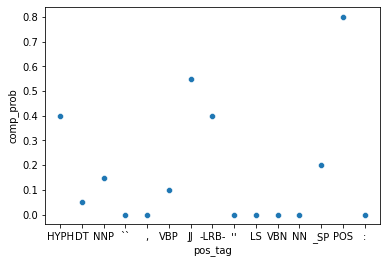

In [28]:
sns.scatterplot(x="pos_tag", y="comp_prob", data=token_3_df);
plt.savefig('postag_scatter.png')